In [1]:
"""Animal classification using CNN and ResNet with Keras and TensorFlow."""
# pylint: disable=no-name-in-module, import-error, no-member
# Final model script with CNN and ResNet50 transfer learning
# Includes training, evaluation, visualization, and metrics.

'Animal classification using CNN and ResNet with Keras and TensorFlow.'

In [ ]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import tensorflow as tf

from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# Copying from Drive to working directory
!cp /content/drive/MyDrive/Colab\ Notebooks/animals10.zip .


In [11]:
# Extract dataset
import zipfile
with zipfile.ZipFile("animals10.zip", 'r') as zip_ref:
    zip_ref.extractall("animals10")

In [23]:
import os

print("Contents of animals10 folder:")
print(os.listdir("animals10"))

Contents of animals10 folder:
['translate.py', 'raw-img']


Classes: ['translate.py', 'raw-img']


In [25]:
# Build dataset
BASE_DIR = "animals10/raw-img"
filepaths, labels = [], []

for class_label in sorted(os.listdir(BASE_DIR)):
    class_dir = os.path.join(BASE_DIR, class_label)
    if os.path.isdir(class_dir):
        for fname in os.listdir(class_dir):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                filepaths.append(os.path.join(class_dir, fname))
                labels.append(class_label)

print("Total images:", len(filepaths))
print("Labels sample:", labels[:5])

Total images: 26179
Labels sample: ['cane', 'cane', 'cane', 'cane', 'cane']


In [26]:
print("Classes:", os.listdir(BASE_DIR))

Classes: ['mucca', 'elefante', 'pecora', 'gatto', 'gallina', 'cavallo', 'farfalla', 'cane', 'ragno', 'scoiattolo']


In [27]:
filepaths = np.array(filepaths)
labels = np.array(labels)

In [28]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

In [29]:
# Train/val/test split
X_train, X_temp, y_train, y_temp = train_test_split(
    filepaths, labels_encoded, test_size=0.2, stratify=labels_encoded, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Confirm sizes
print("Train:", len(X_train), "Val:", len(X_val), "Test:", len(X_test))

Train: 20943 Val: 2618 Test: 2618


In [30]:
# Image dataset from paths
def paths_to_dataset(image_paths, image_labels, image_size=(224, 224), batch_size=32, shuffle=True):
    """Convert image paths and labels into a batched TensorFlow dataset."""
    def load_img(path, class_idx):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, image_size)
        return image, class_idx

    path_ds = tf.data.Dataset.from_tensor_slices((image_paths, image_labels))
    image_ds = path_ds.map(load_img, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        image_ds = image_ds.shuffle(buffer_size=1000)
    return image_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [31]:
# Data augmentation
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomContrast(0.1),
    ]
)

In [32]:
def augment_dataset(dataset):
    """Applies data augmentation to a TensorFlow dataset."""
    return dataset.map(
        lambda x, y: (data_augmentation(x, training=True), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )

In [33]:
# Dataset creation
train_ds = paths_to_dataset(X_train, y_train)
val_ds = paths_to_dataset(X_val, y_val, shuffle=False)
test_ds = paths_to_dataset(X_test, y_test, shuffle=False)
train_ds = augment_dataset(train_ds)
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [34]:
# Class weights
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights_array))

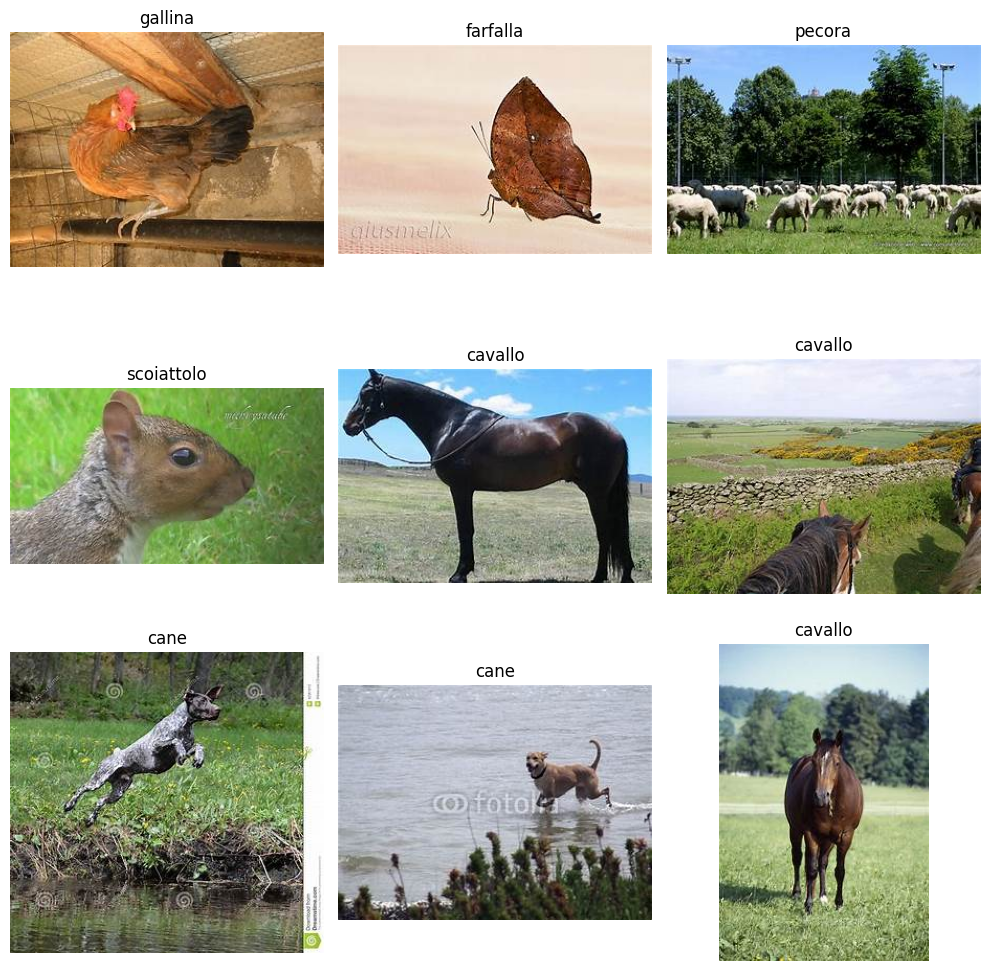

In [35]:
# Visualize sample images from dataset
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_sample_images(filepaths, labels, label_encoder, num_images=9):
    """Displays a grid of sample images with their class labels."""
    plt.figure(figsize=(10, 10))
    indices = np.random.choice(len(filepaths), num_images, replace=False)

    for i, idx in enumerate(indices):
        img = mpimg.imread(filepaths[idx])
        label = label_encoder.inverse_transform([labels[idx]])[0]

        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Display image samples
show_sample_images(filepaths, labels_encoded, label_encoder)

In [109]:
# CNN model definition
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
])

In [ ]:
# Callbacks
EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4) 



In [114]:
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [115]:
# Train CNN
history_cnn = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weights,
    callbacks=callbacks,
)

Epoch 1/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.2531 - loss: 2.0508 - val_accuracy: 0.3197 - val_loss: 2.1116 - learning_rate: 0.0010
Epoch 2/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.4282 - loss: 1.5936 - val_accuracy: 0.3484 - val_loss: 2.0555 - learning_rate: 0.0010
Epoch 3/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.5223 - loss: 1.3490 - val_accuracy: 0.4156 - val_loss: 1.8046 - learning_rate: 0.0010
Epoch 4/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.5828 - loss: 1.1777 - val_accuracy: 0.4771 - val_loss: 1.5965 - learning_rate: 0.0010
Epoch 5/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.6333 - loss: 1.0570 - val_accuracy: 0.5004 - val_loss: 1.4519 - learning_rate: 0.0010
Epoch 6/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.6800 - loss: 0.9122 - val_accuracy: 0.5672 - val_loss: 1.4286 - learning_rate: 0.0010
Epoch 7/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.7118 - l

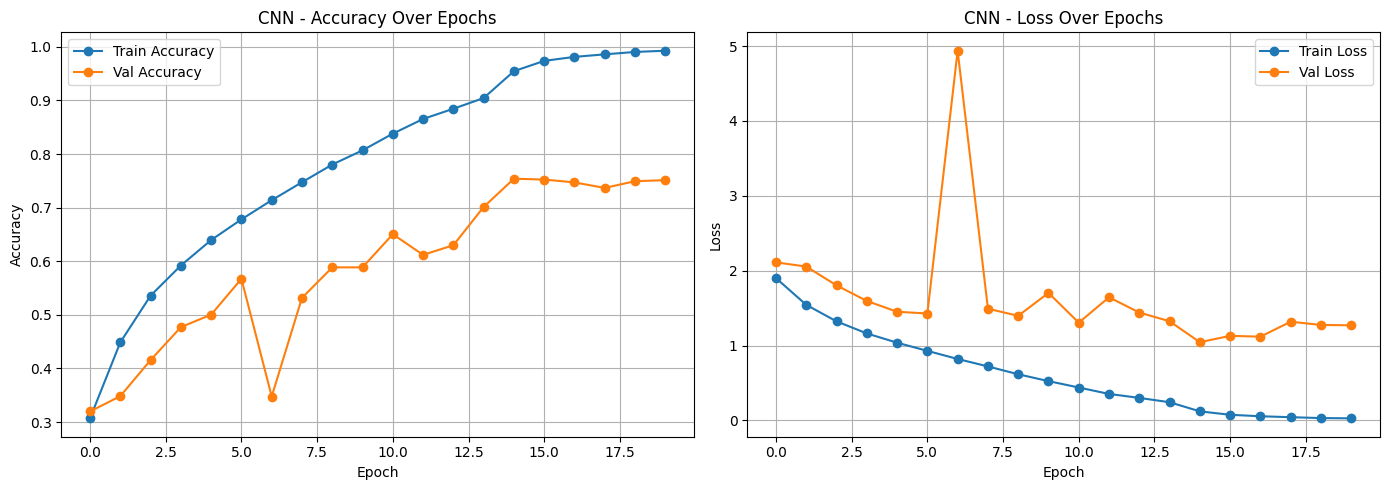

In [116]:
# Plotting CNN Performance
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history_cnn.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title("CNN - Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Train Loss', marker='o')
plt.plot(history_cnn.history['val_loss'], label='Val Loss', marker='o')
plt.title("CNN - Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [117]:
# Evaluate CNN on Test Data
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(test_ds)
y_pred_cnn = np.argmax(cnn_model.predict(test_ds), axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7753 - loss: 0.8974
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


In [118]:
# Classification report for CNN
print(
    "CNN Classification Report:\n",
    classification_report(
        y_true, y_pred_cnn, target_names=label_encoder.classes_
    )
)

CNN Classification Report:
               precision    recall  f1-score   support

        cane       0.86      0.69      0.77       487
     cavallo       0.67      0.79      0.73       262
    elefante       0.56      0.92      0.70       145
    farfalla       0.76      0.87      0.81       211
     gallina       0.71      0.88      0.79       310
       gatto       0.76      0.73      0.74       167
       mucca       0.76      0.51      0.61       186
      pecora       0.69      0.80      0.74       182
       ragno       0.94      0.77      0.85       482
  scoiattolo       0.78      0.69      0.73       186

    accuracy                           0.76      2618
   macro avg       0.75      0.77      0.75      2618
weighted avg       0.78      0.76      0.76      2618



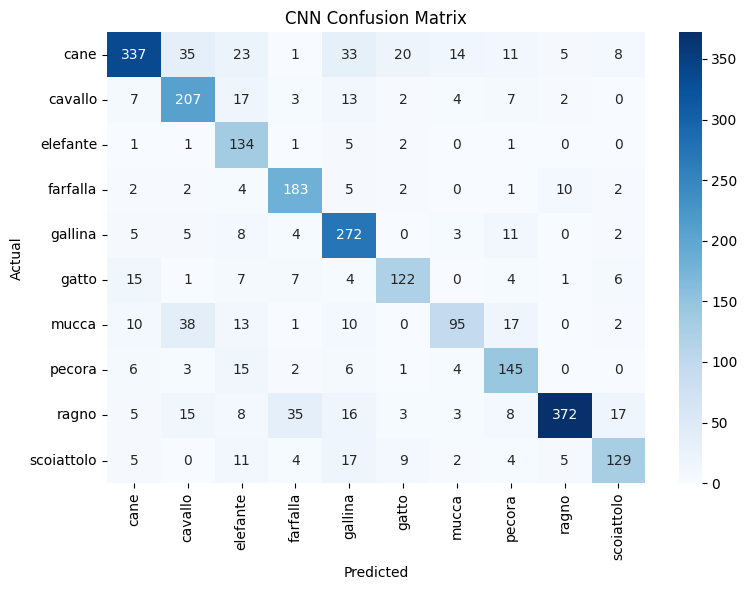

In [119]:
# CNN Confusion matrix
cm = confusion_matrix(y_true, y_pred_cnn)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("CNN Confusion Matrix")
plt.tight_layout()
plt.show()

In [120]:
cnn_model.save("cnn_model.keras")
print("CNN model saved as cnn_model.keras")

CNN model saved as cnn_model.keras


In [121]:
# ResNet Transfer Learning
resnet_base = tf.keras.applications.ResNet50(
    weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_base.trainable = False

In [122]:
resnet_model = models.Sequential([
    resnet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
])

In [123]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
]

In [124]:
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [125]:
# Train ResNet (feature extraction)
history_resnet = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks,
)

Epoch 1/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 31s 33ms/step - accuracy: 0.7690 - loss: 0.7048 - val_accuracy: 0.9377 - val_loss: 0.2049 - learning_rate: 0.0010
Epoch 2/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.8892 - loss: 0.3348 - val_accuracy: 0.9362 - val_loss: 0.1980 - learning_rate: 0.0010
Epoch 3/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.9167 - loss: 0.2541 - val_accuracy: 0.9419 - val_loss: 0.1887 - learning_rate: 0.0010
Epoch 4/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.9236 - loss: 0.2246 - val_accuracy: 0.9343 - val_loss: 0.2272 - learning_rate: 0.0010
Epoch 5/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.9332 - loss: 0.2002 - val_accuracy: 0.9351 - val_loss: 0.2199 - learning_rate: 0.0010
Epoch 6/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.9330 - loss: 0.1892 - val_accuracy: 0.9347 - val_loss: 0.2276 - learning_rate: 0.0010
Epoch 7/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.9569 - l

In [126]:
# Fine-tune ResNet
resnet_base.trainable = True

resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_resnet_finetuned = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks,
)

Epoch 1/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 110s 90ms/step - accuracy: 0.9127 - loss: 0.2671 - val_accuracy: 0.9565 - val_loss: 0.1694 - learning_rate: 1.0000e-05
Epoch 2/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 33s 51ms/step - accuracy: 0.9781 - loss: 0.0767 - val_accuracy: 0.9607 - val_loss: 0.1570 - learning_rate: 1.0000e-05
Epoch 3/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 33s 51ms/step - accuracy: 0.9930 - loss: 0.0305 - val_accuracy: 0.9652 - val_loss: 0.1625 - learning_rate: 1.0000e-05
Epoch 4/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 33s 51ms/step - accuracy: 0.9978 - loss: 0.0128 - val_accuracy: 0.9629 - val_loss: 0.1827 - learning_rate: 1.0000e-05
Epoch 5/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 33s 50ms/step - accuracy: 0.9991 - loss: 0.0069 - val_accuracy: 0.9645 - val_loss: 0.1964 - learning_rate: 1.0000e-05
Epoch 6/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 33s 51ms/step - accuracy: 0.9995 - loss: 0.0046 - val_accuracy: 0.9660 - val_loss: 0.1913 - learning_rate: 2.0000e-06
Epoch 7/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 33s 51ms/st

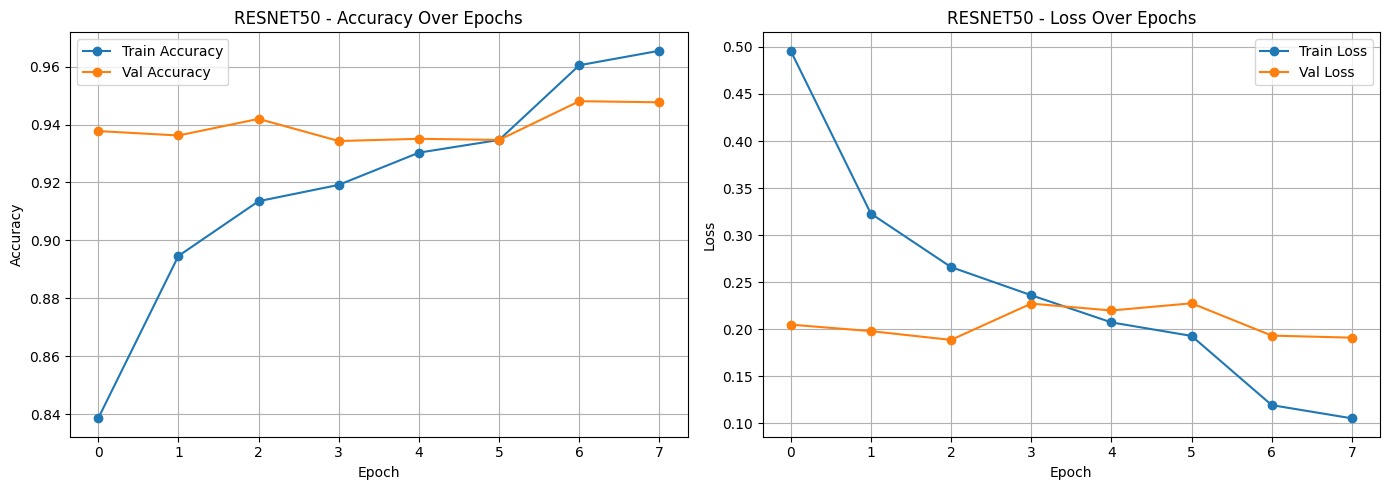

In [127]:
# Plotting RESNET50 Performance
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history_resnet.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title("RESNET50 - Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['loss'], label='Train Loss', marker='o')
plt.plot(history_resnet.history['val_loss'], label='Val Loss', marker='o')
plt.title("RESNET50 - Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [128]:
# Evaluate ResNet
resnet_test_loss, resnet_test_acc = resnet_model.evaluate(test_ds)
y_pred_resnet = np.argmax(resnet_model.predict(test_ds), axis=1)

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9644 - loss: 0.1520
82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step


In [129]:
# ResNet classification report
print(
    "ResNet Classification Report:\n",
    classification_report(
        y_true, y_pred_resnet, target_names=label_encoder.classes_
    )
)

ResNet Classification Report:
               precision    recall  f1-score   support

        cane       0.96      0.96      0.96       487
     cavallo       0.94      0.95      0.94       262
    elefante       0.93      0.97      0.95       145
    farfalla       0.98      0.97      0.97       211
     gallina       0.98      0.98      0.98       310
       gatto       0.95      0.95      0.95       167
       mucca       0.95      0.90      0.92       186
      pecora       0.91      0.95      0.92       182
       ragno       0.99      0.99      0.99       482
  scoiattolo       0.98      0.97      0.98       186

    accuracy                           0.96      2618
   macro avg       0.96      0.96      0.96      2618
weighted avg       0.96      0.96      0.96      2618



<function matplotlib.pyplot.show(close=None, block=None)>

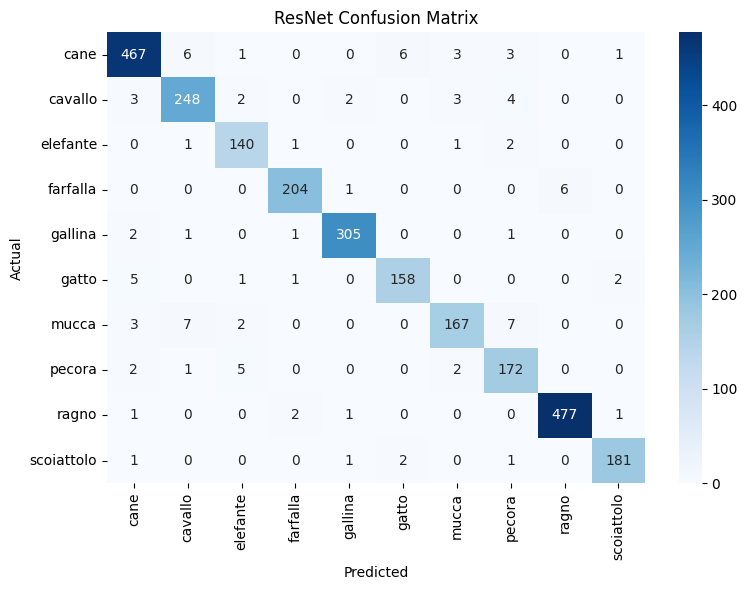

In [130]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred_resnet)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("ResNet Confusion Matrix")
plt.tight_layout()
plt.show

In [131]:
resnet_model.save("resnet_model.keras")
print("ResNet model saved as resnet_model.keras")

ResNet model saved as resnet_model.keras


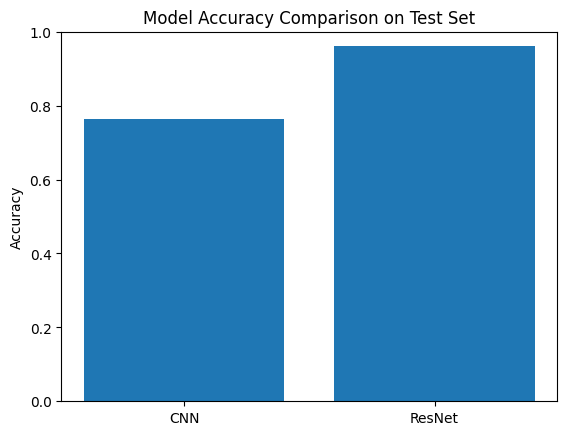

In [132]:
# Accuracy comparison
model_names = ['CNN', 'ResNet']
accuracies = [cnn_test_acc, resnet_test_acc]
plt.bar(model_names, accuracies)
plt.ylim(0, 1)
plt.title("Model Accuracy Comparison on Test Set")
plt.ylabel("Accuracy")
plt.show()

In [133]:
from sklearn.metrics import classification_report

report_cnn = classification_report(y_true, y_pred_cnn, output_dict=True)
report_resnet = classification_report(y_true, y_pred_resnet, output_dict=True)

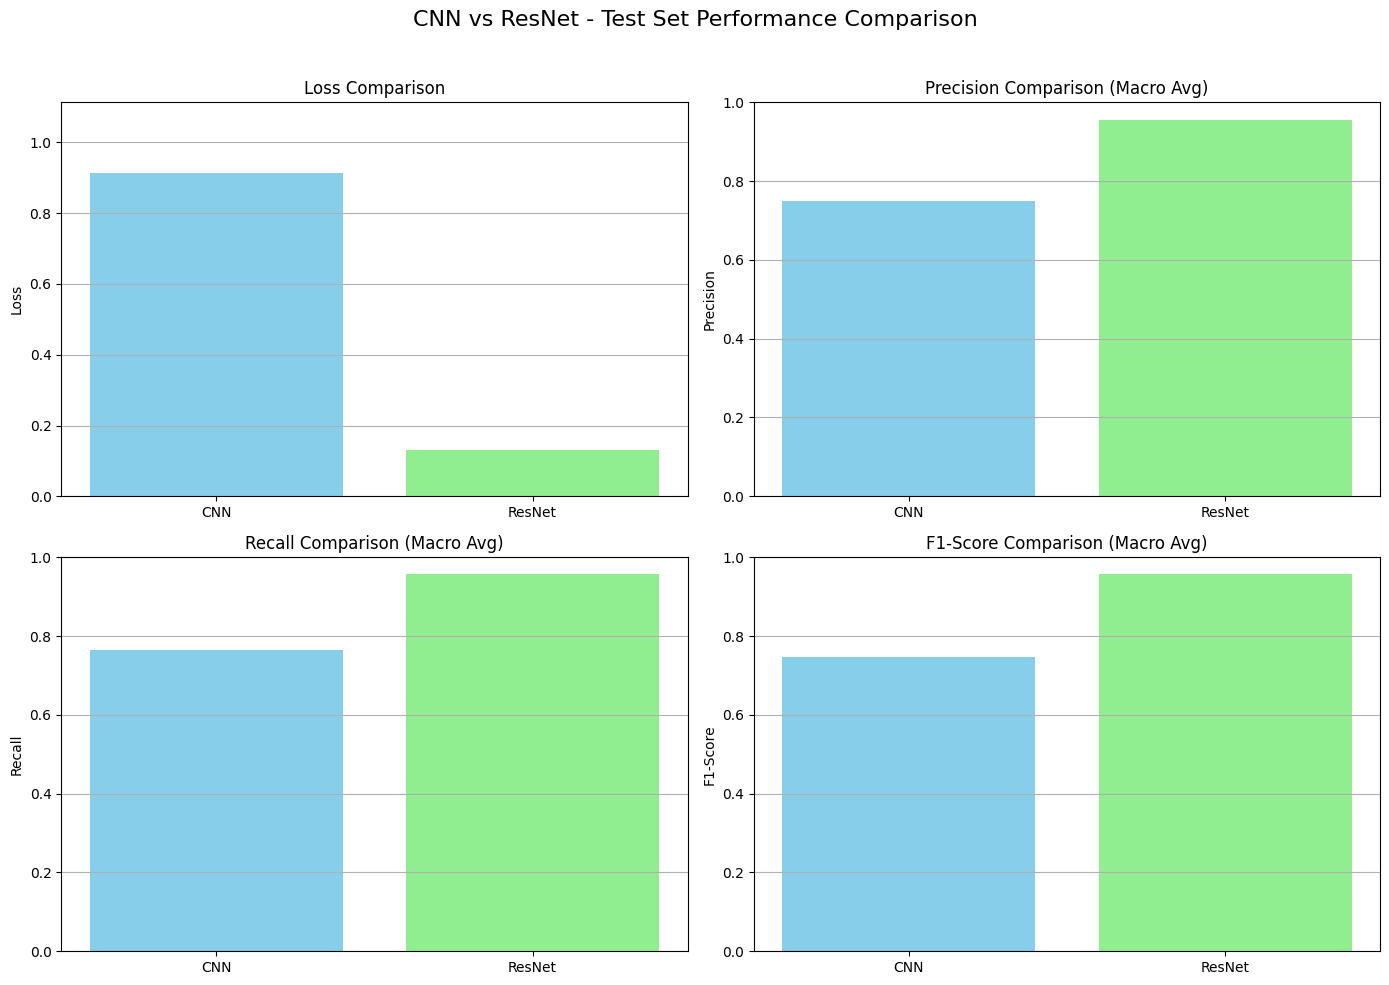

In [138]:
# Model names
model_names = ['CNN', 'ResNet']

# Metrics (replace these with your actual values)
losses = [cnn_test_loss, resnet_test_loss]
precisions = [cnn_precision, resnet_precision]
recalls = [cnn_recall, resnet_recall]
f1_scores = [cnn_f1, resnet_f1]

# Plotting
plt.figure(figsize=(14, 10))

# 1. Loss
plt.subplot(2, 2, 1)
plt.bar(model_names, losses, color=['skyblue', 'lightgreen'])
plt.title("Loss Comparison")
plt.ylabel("Loss")
plt.ylim(0, max(losses) + 0.2)
plt.grid(axis='y')

# 2. Precision
plt.subplot(2, 2, 2)
plt.bar(model_names, precisions, color=['skyblue', 'lightgreen'])
plt.title("Precision Comparison (Macro Avg)")
plt.ylabel("Precision")
plt.ylim(0, 1)
plt.grid(axis='y')

# 3. Recall
plt.subplot(2, 2, 3)
plt.bar(model_names, recalls, color=['skyblue', 'lightgreen'])
plt.title("Recall Comparison (Macro Avg)")
plt.ylabel("Recall")
plt.ylim(0, 1)
plt.grid(axis='y')

# 4. F1-Score
plt.subplot(2, 2, 4)
plt.bar(model_names, f1_scores, color=['skyblue', 'lightgreen'])
plt.title("F1-Score Comparison (Macro Avg)")
plt.ylabel("F1-Score")
plt.ylim(0, 1)
plt.grid(axis='y')

plt.suptitle("CNN vs ResNet - Test Set Performance Comparison", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
